# Week 4: NLP Disaster Tweets Kaggle Mini-Project


---

Introduction:  
This project will be based on the following Kaggle competition - [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview).  
The basis for this competition is to classify tweets as having to do with a natural disaster or not. As with other projects in this course, I will complete the following sections:  
*  Description of the problem and data.
*  EDA - Inspect, visualize and clean the data.
*  Build a model to classify the tweets
*  Results and Analysis
*  Conclusion


---

# Problem Statement and Data  
  
As stated above, this project is based on Natural Language Processing. The goal is to build a model that can classify a tweet based on the probability that it is announcing a disaster.  
  
Data:  
The data contains a training set that has about 7,600 example tweets with the following columns of data: id, keyword, location, text and target.  There is also a test set that contains about 3,200 additional examples with the same columns except for target.  
This project will build a model using the training data, then test the model on the test set and submit to Kaggle.com for analysis. The competition bases the analysis on the F1 score where F1 = 2 * (precision * recall)/(precision + recall).



---

# Import Libraries


---



In [1]:
# Install necessary libraries
!pip install kaggle wordcloud nltk --quiet

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import os
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




---

# Load Data


---



In [3]:
# Define data path
data_path = "/content/drive/My Drive/Colab Notebooks/week4NLP"

# Load data
train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
test_df = pd.read_csv(os.path.join(data_path, "test.csv"))



---

# EDA


---



Get high level information on training and test data sets.

In [4]:
# Check data
print(train_df.info())
print(train_df.head())
print(test_df.info())
print(test_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.frame.DataFrame'



---


Check for balance of the target class

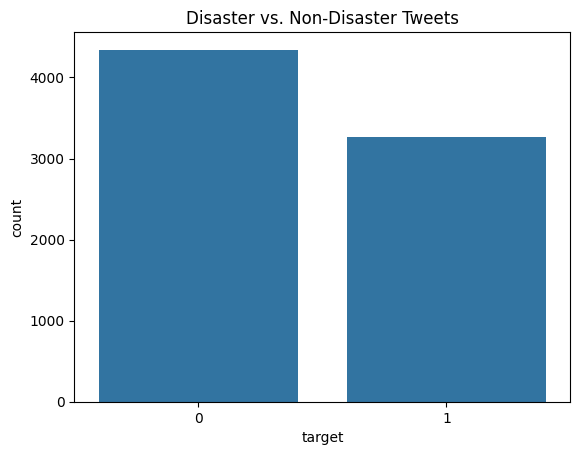

In [5]:
# Check label distribution
sns.countplot(x=train_df["target"])
plt.title("Disaster vs. Non-Disaster Tweets")
plt.show()



---


Clean the text data.

In [6]:
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))
lemmatizer = nltk.WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters
    words = word_tokenize(text)  # Tokenization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Remove stopwords & lemmatize
    return " ".join(words)

train_df["clean_text"] = train_df["text"].apply(clean_text)
test_df["clean_text"] = test_df["text"].apply(clean_text)

# Preview cleaned text
print(train_df[["text", "clean_text"]].head())
print(test_df[["text", "clean_text"]].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                          clean_text  
0         deed reason earthquake may allah forgive u  
1              forest fire near la ronge sask canada  
2  resident asked shelter place notified officer ...  
3  people receive wildfire evacuation order calif...  
4  got sent photo ruby alaska smoke wildfire pour...  
                                                text  \
0                 Just happened a terrible car crash   
1  Heard about #earthquake is different cities, s...   
2  there is a forest fire at spot pond, geese are...   
3           Apocalypse lighting. #Spokane #wildfires   
4      Typhoon Soudelor kills 28 in China and Taiwan 


---

Build wordclouds for tweets classified as positive and negative for disaster.


In [7]:
disaster_text = " ".join(train_df[train_df["target"] == 1]["clean_text"])
non_disaster_text = " ".join(train_df[train_df["target"] == 0]["clean_text"])

wordcloud = WordCloud(width=800, height=400, background_color='red', colormap='viridis').generate(disaster_text)
wordcloud_non = WordCloud(width=800, height=400, background_color='white', colormap='coolwarm').generate(non_disaster_text)

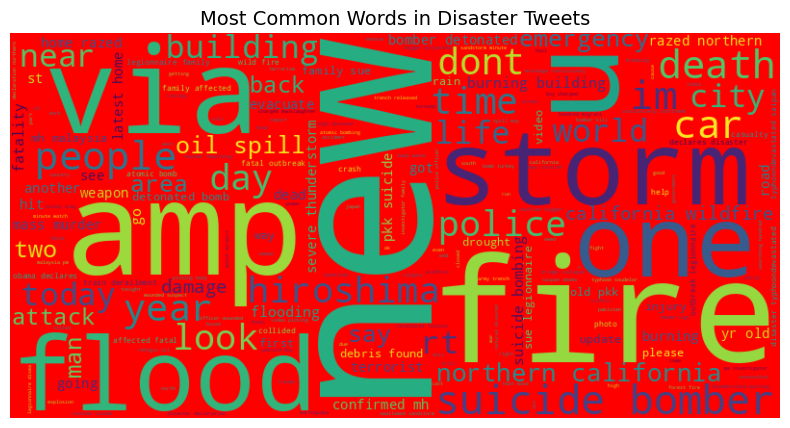

In [8]:
# Plot Word Cloud for Positive tweets
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.title("Most Common Words in Disaster Tweets", fontsize=14)
plt.show()

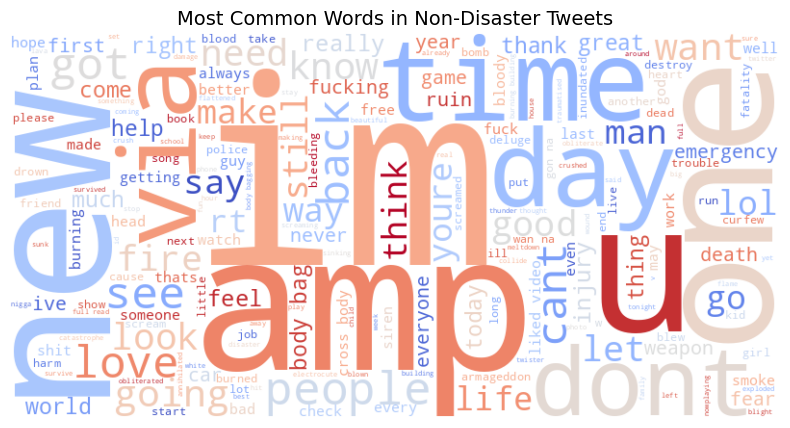

In [9]:
# Plot Word Cloud for Negative tweets
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_non, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Non-Disaster Tweets", fontsize=14)
plt.show()



---

Tokanize text

In [10]:
# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_df["clean_text"])
X_seq = tokenizer.texts_to_sequences(train_df["clean_text"])
X_pad = pad_sequences(X_seq, maxlen=50)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_pad, train_df["target"], test_size=0.2, random_state=42)



---

# Build Models


---

I'm going to build the following neural network models to see which works the best, then use that model to fit the test data and submit to kaggle.
*  LSTM
*  GRU
*  Bidirectional GRU

**LSTM**

In [11]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=50),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)



---

Train the LTSM model.

In [12]:
history_lstm = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6120 - loss: 0.6455 - val_accuracy: 0.8011 - val_loss: 0.4528
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8599 - loss: 0.3874 - val_accuracy: 0.7840 - val_loss: 0.4710
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8987 - loss: 0.3074 - val_accuracy: 0.7682 - val_loss: 0.5662
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9149 - loss: 0.2559 - val_accuracy: 0.7669 - val_loss: 0.5951
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9350 - loss: 0.1792 - val_accuracy: 0.7479 - val_loss: 0.7338


**GRU**

In [13]:
model_gru = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=50),
    GRU(128, return_sequences=True),
    GRU(64),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


---

Train the GRU model.

In [14]:
history_gru = model_gru.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6657 - loss: 0.5986 - val_accuracy: 0.7873 - val_loss: 0.4581
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8727 - loss: 0.3415 - val_accuracy: 0.7794 - val_loss: 0.4786
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9095 - loss: 0.2652 - val_accuracy: 0.7656 - val_loss: 0.5899
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9340 - loss: 0.1912 - val_accuracy: 0.7551 - val_loss: 0.7124
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9537 - loss: 0.1307 - val_accuracy: 0.7669 - val_loss: 0.8119


**Bidirectional GRU**

In [15]:
model_bi_gru = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=50),
    Bidirectional(GRU(128, return_sequences=True)),
    GRU(64),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_bi_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bi_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


---

Train the Bidirectional GRU model.

In [16]:
history_bi_gru = model_bi_gru.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6782 - loss: 0.6105 - val_accuracy: 0.7846 - val_loss: 0.4687
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8740 - loss: 0.3380 - val_accuracy: 0.7676 - val_loss: 0.4996
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9176 - loss: 0.2384 - val_accuracy: 0.7761 - val_loss: 0.5531
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9510 - loss: 0.1566 - val_accuracy: 0.7492 - val_loss: 0.6762
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9552 - loss: 0.1249 - val_accuracy: 0.7590 - val_loss: 0.9076


# Results and Analysis


---


Compare the 3 models:

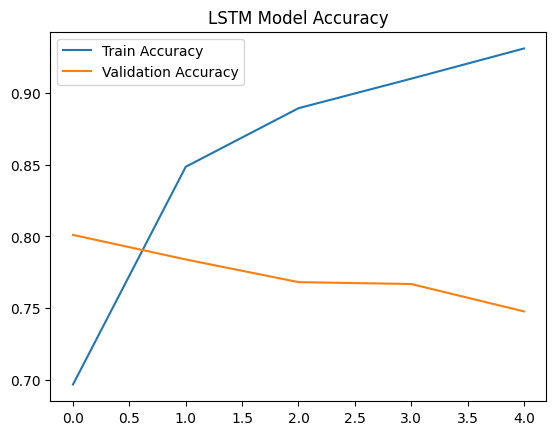

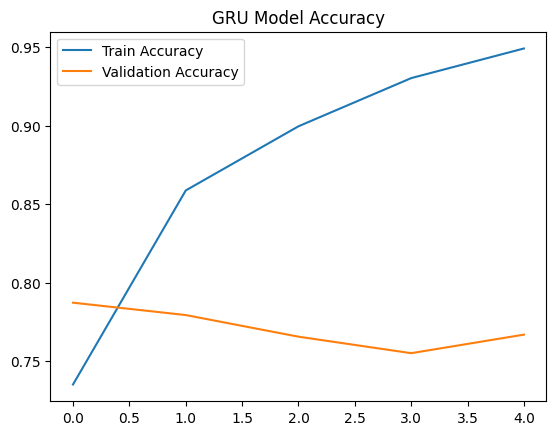

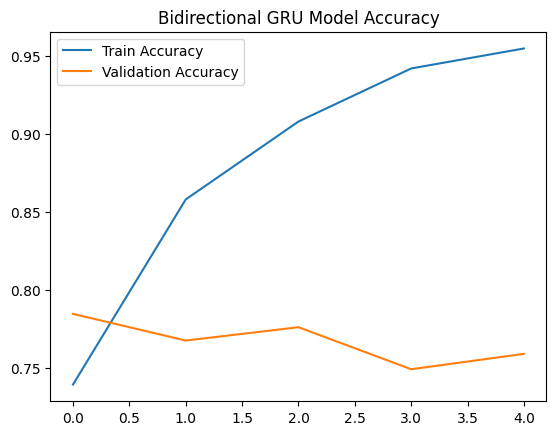

In [17]:
def plot_accuracy(history, title):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title(title)
    plt.show()

# Plot for LSTM
plot_accuracy(history_lstm, 'LSTM Model Accuracy')

# Plot for GRU
plot_accuracy(history_gru, 'GRU Model Accuracy')

# Plot for Bidirectional GRU
plot_accuracy(history_bi_gru, 'Bidirectional GRU Model Accuracy')



---

#  Model comparisons:
  
All models reach a high training accuracy, which indicates that they are learning well, but the validation accuracies plateau which suggest that the models are overfitting the training sets.  High validation loss backs up the possibility that overfitting is ocurring.  
  
In comparing the accuracies and losses, GRU and Bidirectional GRU seem to have the best balance.  
  
I will proceed with GRU to adjust some hyperparameters to see if I can improve on the model.  
  




---
# Hyperparameter Tuning
  
Given the potential for overfitting, I will increase the dropout rate to 0.3.    
  
I will also attempt to help the model generalize by lowering the learning rate to 0.0005.


In [25]:
from tensorflow.keras.optimizers import Adam

model_gru_new = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=50),
    GRU(128, return_sequences=True),
    Dropout(0.4),
    GRU(64),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

new_optimizer = Adam(learning_rate=0.0001)

model_gru_new.compile(loss='binary_crossentropy', optimizer=new_optimizer, metrics=['accuracy'])
model_gru_new.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_12 (GRU)                         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_13 (GRU)                         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [26]:
history_gru_new = model_gru_new.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5655 - loss: 0.6828 - val_accuracy: 0.6133 - val_loss: 0.6449
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6655 - loss: 0.6390 - val_accuracy: 0.7794 - val_loss: 0.5450
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8245 - loss: 0.4684 - val_accuracy: 0.7905 - val_loss: 0.4502
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8697 - loss: 0.3320 - val_accuracy: 0.7892 - val_loss: 0.4620
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8951 - loss: 0.2896 - val_accuracy: 0.7748 - val_loss: 0.5159


# Conclusions  


---

The new model still shows signs of overfitting so there is more room for improving the model.
  
Further hyperparameter tuning could include optimization of the dropout and learning rates, add early stopping and possibly adding a pretrained word embedding.  




---

# Make predictions for Kaggle



In [27]:
X_test_final = tokenizer.texts_to_sequences(test_df["clean_text"])
X_test_final = pad_sequences(X_test_final, maxlen=50)

# Predict with GRU_new model
test_predictions = (model_gru_new.predict(X_test_final) > 0.5).astype(int)

# Create submission file
submission = pd.DataFrame({'id': test_df['id'], 'target': test_predictions.flatten()})
submission_csv_path = "/content/submission.csv"
submission.to_csv(submission_csv_path, index=False)

print(f"Submission file saved at: {submission_csv_path}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Submission file saved at: /content/submission.csv


In [28]:
# Download file for submission to kaggle.com
from google.colab import files
files.download("/content/submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Note: the submission file was submitted to kaggle.com.